# Trackpy Analysis from Cellpose Masks
This notebook extracts cell centroids from Cellpose output masks and tracks them using Trackpy.

In [4]:
# === Imports ===
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.measure import regionprops, label
import matplotlib.pyplot as plt
import trackpy as tp
from tqdm import tqdm

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [01:39<00:00,  2.90it/s]


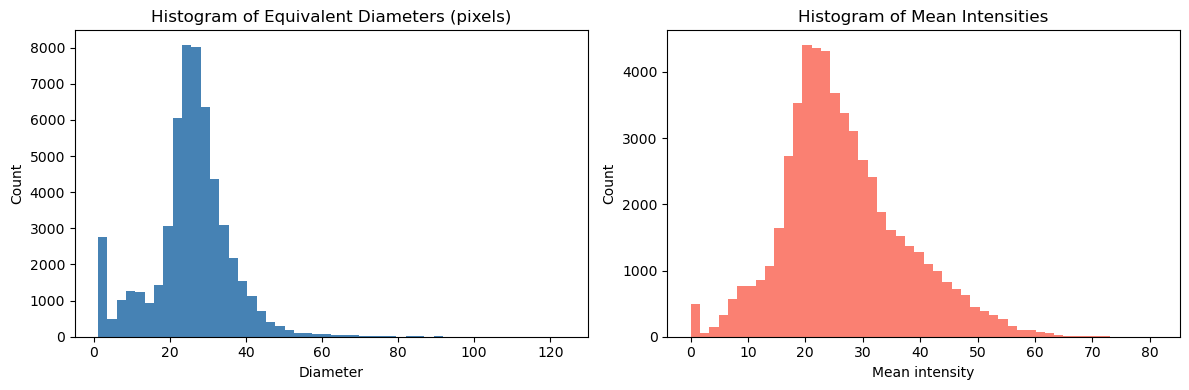

In [5]:
# === Extract equivalent diameter and mean intensity for all masks ===
mask_dir = '/mnt/storage_sda/Projects/imaging_data/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-43-F8-F08/cellpose_outputs'
image_dir = '/mnt/storage_sda/Projects/imaging_data/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-43-F8-F08/enhanced_rgb_frames'
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('_mask.tif')])
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.tif')])

diameter_list = []
intensity_list = []

for mask_fname, image_fname in tqdm(zip(mask_files, image_files), total=len(mask_files)):
    mask = imread(os.path.join(mask_dir, mask_fname))
    image = imread(os.path.join(image_dir, image_fname))

    if image.ndim == 3:
        image = image.mean(axis=-1)

    regions = regionprops(label(mask), intensity_image=image)
    for r in regions:
        diameter_list.append(r.equivalent_diameter)
        intensity_list.append(r.mean_intensity)

# === Plot histograms ===
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(diameter_list, bins=50, color='steelblue')
axs[0].set_title('Histogram of Equivalent Diameters (pixels)')
axs[0].set_xlabel('Diameter')
axs[0].set_ylabel('Count')

axs[1].hist(intensity_list, bins=50, color='salmon')
axs[1].set_title('Histogram of Mean Intensities')
axs[1].set_xlabel('Mean intensity')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [6]:
# === Filter masks and extract centroids based on diameter and intensity percentiles ===
d_low, d_high = np.percentile(diameter_list, [.5, 99.5])
i_low, i_high = np.percentile(intensity_list, [.5, 99.5])

print(f"Filtering diameters in range: {d_low:.2f} – {d_high:.2f}")
print(f"Filtering intensities in range: {i_low:.2f} – {i_high:.2f}")

all_points = []

for frame_num, (mask_fname, image_fname) in enumerate(tqdm(zip(mask_files, image_files), total=len(mask_files))):
    mask = imread(os.path.join(mask_dir, mask_fname))
    image = imread(os.path.join(image_dir, image_fname))
    
    if image.ndim == 3:
        image = image.mean(axis=-1)

    regions = regionprops(label(mask), intensity_image=image)

    for r in regions:
        if d_low <= r.equivalent_diameter <= d_high and i_low <= r.mean_intensity <= i_high:
            y, x = r.centroid
            all_points.append({
                'frame': frame_num,
                'y': y,
                'x': x
            })

df = pd.DataFrame(all_points)
df.head()



Filtering diameters in range: 1.13 – 62.31
Filtering intensities in range: 0.00 – 58.79


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [01:45<00:00,  2.74it/s]


,frame,y,x
0,0,39.045000,1622.810000
1,0,45.445504,421.483651
2,0,56.583942,1381.943066
3,0,58.956693,1570.972441
4,0,69.074523,1726.937608


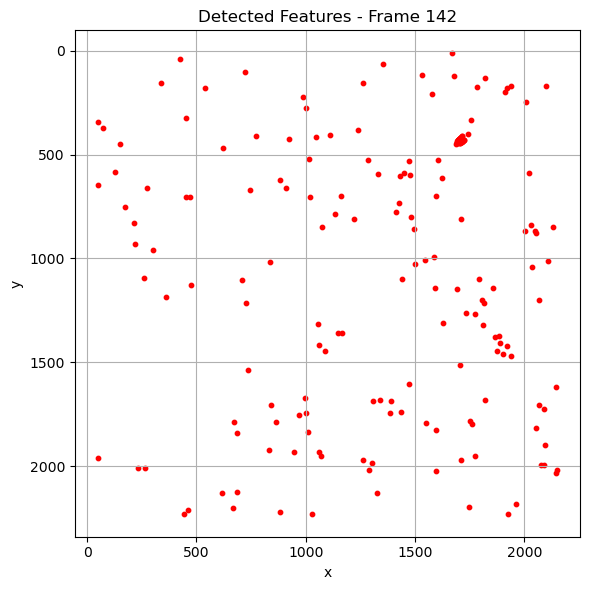

In [9]:
import matplotlib.pyplot as plt

df_142 = df[df['frame'] == 143]

plt.figure(figsize=(6, 6))
plt.scatter(df_142['x'], df_142['y'], s=10, color='red')
plt.title('Detected Features - Frame 142')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().invert_yaxis()  # Flip y-axis to match image orientation
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
df_filtered = df.groupby('frame').filter(lambda x: len(x) <= 220)

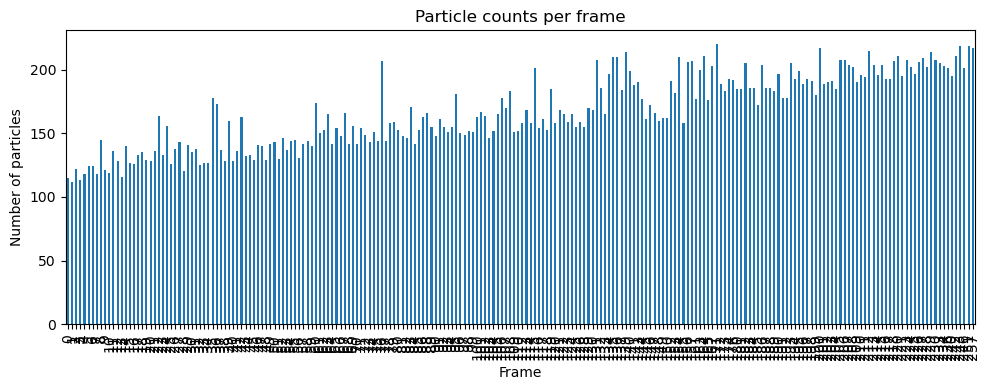

frame
171    220
251    219
243    219
257    217
200    217
Name: count, dtype: int64


In [12]:
# Count number of particles in each frame
frame_counts = df_filtered['frame'].value_counts().sort_index()

# Plot number of features per frame
plt.figure(figsize=(10, 4))
frame_counts.plot(kind='bar')
plt.xlabel('Frame')
plt.ylabel('Number of particles')
plt.title('Particle counts per frame')
plt.tight_layout()
plt.show()
print(frame_counts.sort_values(ascending=False).head())


In [15]:
# === Link with Trackpy ===
linked = tp.link_df(df_filtered, search_range=15, memory=2)
linked.head()

Frame 131: 208 trajectories present.


SubnetOversizeException: Subnetwork contains 38 points

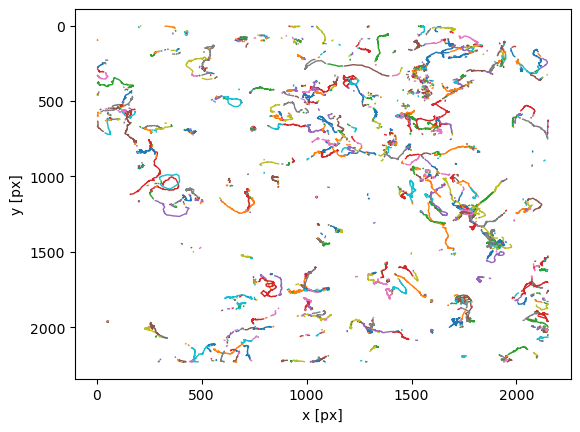

Text(24.0, 0.5, 'y')

In [30]:
ax = tp.plot_traj(linked)
ax.invert_yaxis()
ax.set_title('Tracked trajectories')
ax.set_xlabel('x')
ax.set_ylabel('y')


In [31]:
#save the tracks to a pandas dataframe
os.makedirs('/mnt/storage_sda/Projects/imaging_data/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-43-F8-F08/tracks', exist_ok=True)
linked.to_csv('/mnt/storage_sda/Projects/imaging_data/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-43-F8-F08/tracks/linked_tracks.csv', index=False)

#for future loading of the same dataframe:
#linked = pd.read_csv('./s28_tracks/linked_tracks.csv')

In [15]:
#imports for making a movie
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib import cm

In [32]:
#generate frames for a movie, by overlaying cell tracks

# === Parameters ===
#image_dir = '/mnt/storage_sda/Projects/imaging_data/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-29-E3-E03/enhanced_rgb_frames'
output_dir = '/mnt/storage_sda/Projects/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-43-F8-F08/tracks/movie_frames'
os.makedirs(output_dir, exist_ok=True)
video_path = '/mnt/storage_sda/Projects/imaging_data/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-43-F8-F08/tracks/movie_frames/tracks_movie.mp4'

# === Parameters ===
tail_length = 15  # number of frames to show tail history
#output_dir = './s28_tracks/track_frames'
#os.makedirs(output_dir, exist_ok=True)

# === Colormap setup ===
cmap = plt.get_cmap('tab10')  # change to another if you want e.g., 'gist_ncar'

# === Load base frame for size info ===
sample_img = imread(os.path.join(image_dir, image_files[0]))
height, width = sample_img.shape[:2]

for fnum, img_name in enumerate(tqdm(image_files, desc="Rendering frames with tracks")):
    vis = imread(os.path.join(image_dir, img_name))
    if vis.ndim == 3:
        vis = vis.mean(axis=-1)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(vis, cmap='gray', vmin=vis.min(), vmax=vis.max())
    ax.set_axis_off()

    # Overlay all track tails for this frame
    for pid in linked['particle'].unique():
        traj = linked[linked['particle'] == pid]
        tail = traj[(traj['frame'] <= fnum) & (traj['frame'] > fnum - tail_length)]

        if len(tail) > 1:
            ax.plot(tail['x'], tail['y'], '-', linewidth=2, alpha=0.8,
                    color=cmap(int(pid) % 10))

    # Save to file
    out_path = os.path.join(output_dir, f"{fnum:04d}.png")
    fig.savefig(out_path, dpi=100, bbox_inches='tight', pad_inches=0)
    plt.close(fig)



Rendering frames with tracks: 100%|████████████████████████████████████████████████████████████████████████████| 289/289 [30:45<00:00,  6.39s/it]


In [33]:
#combine generated frames into a movie

import subprocess

# === Define paths ===
input_pattern = '/mnt/storage_sda/Projects/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-43-F8-F08/tracks/movie_frames/%04d.png'
output_video = '/mnt/storage_sda/Projects/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-43-F8-F08/tracks/movie_frames/track_overlay.mp4'
fps = 10  # Adjust as needed

# === FFmpeg command with padding to ensure even width/height ===
ffmpeg_cmd = [
    'ffmpeg',
    '-y',  # Overwrite output file if exists
    '-framerate', str(fps),
    '-i', input_pattern,
    '-vf', 'pad=ceil(iw/2)*2:ceil(ih/2)*2',
    '-c:v', 'libx264',
    '-pix_fmt', 'yuv420p',
    output_video
]

# === Run the command ===
print("Running FFmpeg...")
subprocess.run(ffmpeg_cmd, check=True)
print(f"Saved movie to {output_video}")


Running FFmpeg...


ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.4.0 (GCC)
  configuration: --prefix=/home/mars/anaconda3/envs/snyder --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1635121324509/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1635121324509/_build_env/bin/pkg-config
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.134.100
  libavformat    58. 76.100 / 58. 76.100
  libavdevice    58. 13.100 / 58. 13.100
  libavfilter     7.110.100 /  7.110.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  9.100 /  5. 

Saved movie to /mnt/storage_sda/Projects/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-43-F8-F08/tracks/movie_frames/track_overlay.mp4


frame=  289 fps= 84 q=-1.0 Lsize=    1050kB time=00:00:28.60 bitrate= 300.7kbits/s speed= 8.3x    
video:1046kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.391999%
[libx264 @ 0x622c03378480] frame I:2     Avg QP:17.68  size: 10296
[libx264 @ 0x622c03378480] frame P:109   Avg QP:20.12  size:  5227
[libx264 @ 0x622c03378480] frame B:178   Avg QP:21.44  size:  2694
[libx264 @ 0x622c03378480] consecutive B-frames:  7.6% 24.9% 17.6% 49.8%
[libx264 @ 0x622c03378480] mb I  I16..4: 27.6% 42.0% 30.4%
[libx264 @ 0x622c03378480] mb P  I16..4:  2.4%  3.9%  0.8%  P16..4: 47.7% 13.1% 11.6%  0.0%  0.0%    skip:20.5%
[libx264 @ 0x622c03378480] mb B  I16..4:  1.8%  1.5%  0.1%  B16..8: 46.5%  8.7%  3.6%  direct:10.7%  skip:27.0%  L0:49.6% L1:44.6% BI: 5.8%
[libx264 @ 0x622c03378480] 8x8 transform intra:49.2% inter:67.6%
[libx264 @ 0x622c03378480] coded y,uvDC,uvAC intra: 37.1% 5.4% 3.8% inter: 31.6% 5.5% 4.8%
[libx264 @ 0x622c03378480] i16 v,h,dc,p: 40% 18% 12% 30%
[li

In [34]:
from IPython.display import Video

Video(output_video, embed=True)